<!-- Assignment 7 - SS 2022 -->

# Bayesian Deep Learning (5 points)

This notebook contains one of the assignments for the exercises in Deep Learning and Neural Nets 2.
It provides a skeleton, i.e. code with gaps, that will be filled out by you in different exercises.
All exercise descriptions are visually annotated by a vertical bar on the left and some extra indentation,
unless you already messed with your jupyter notebook configuration.
Any questions that are not part of the exercise statement do not need to be answered,
but should rather be interpreted as triggers to guide your thought process.

**Note**: The cells in the introductory part (before the first subtitle)
perform all necessary imports and provide utility functions that should work without (too much) problems.
Please, do not alter this code or add extra import statements in your submission, unless explicitly allowed!

<span style="color:#d95c4c">**IMPORTANT:**</span> Please, change the name of your submission file so that it contains your student ID!

In this assignment, we take a look at Bayesian deep learning.
After a gentle introduction through Gaussian processes,
Bayesian neural networks are introduced.
Eventually, the goal of this assignment is to get a simple BNN to learn.

In [21]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch import distributions
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision import transforms

torch.manual_seed(1806)
torch.cuda.manual_seed(1806)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

data_root = "~/.pytorch"
print(data_root)

cpu
~/.pytorch


In [22]:
# google colab data management
import os.path

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    _home = 'gdrive/MyDrive/'
except ImportError:
    _home = '~'
finally:
    data_root = os.path.join(_home, '.pytorch')

print(data_root)

~\.pytorch


In [23]:
@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metrics: dict) -> list:
    network.eval()
    device = next(network.parameters()).device
    
    results = {k: [] for k in metrics} 
    for x, y in data:
        x, y = x.to(device), y.to(device)
        logits = network(x)
        for k, func in metrics.items():
            results[k].append(func(logits, y).item())

    return results


@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module,
           opt: optim.Optimizer, regulariser: nn.Module = None) -> list:
    network.train()
    device = next(network.parameters()).device

    errs = []
    for x, y in data:
        x, y = x.to(device), y.to(device)
        logits = network(x)
        err = loss(logits, y)
        errs.append(err.item())

        opt.zero_grad()
        err.backward()
        opt.step()

    return errs

In [24]:
@torch.no_grad()
def accuracy(logits, y):
    """ Compute the accuracy of a prediction. """
    correct = logits.argmax(dim=1) == y
    return torch.mean(correct.float(), dim=0)

In [25]:
def train(net, train_samples, objective, optimiser, 
          valid_samples, val_metrics, num_epochs: int = 20, print_every: int = 5):
    """
    Train a network for a number of epochs.
    
    Parameters
    ----------
    net : nn.Module
        The network to train
    train_samples : DataLoader
        The training data in mini-batches
    objective : callable
        The loss function to optimise during training
    optimiser : optim.Optimizer
        The optimiser to use for updating the network
    valid_samples : DataLoader
        The validation data in mini-batches
    val_metrics : dict
        A dict mapping strings to metric functions.
        These metrics will be computed on the validation data
        and the results are printed with the corresponding key.
    num_epochs : int, optional
        The number of epochs to train.
    print_every : int, optinal
        The number of epochs to wait before the next print statement.
    """
    valid_errs = evaluate(net, valid_samples, val_metrics)
    msg = ", ".join((f"{k}: {v[-1]:.5f}" for k, v in valid_errs.items()))
    print("Epoch 00", "-", msg)
    for epoch in range(1, num_epochs + 1):
        train_errs = update(net, train_samples, objective, optimiser)
        if epoch % print_every == 0:
            valid_errs = evaluate(net, valid_samples, val_metrics)
            msg = ", ".join((f"{k}: {v[-1]:.5f}" for k, v in valid_errs.items()))
            print(f"Epoch {epoch:02d}", "-", msg)

In [26]:
def plot_gp(x_test: torch.Tensor, gp: 'GaussianProcess', ax=None):
    """
    Visualise Gaussian Process given test points.
    
    Parameters
    ----------
    x_test : torch.Tensor
        The points at which the GP is to be evaluated.
    gp : GaussianProcess
        The GP to be visualised.
    ax : plt.axis, optional
        The axis for visualisation.
    
    Returns
    -------
    ax : plt.axis
        The axis on which the GP has been visualised
    """
    if ax is None:
        ax = plt.gca()
    
    mu, sigma = gp(x_test)
    ax.fill_between(x_test, mu - sigma, mu + sigma, 
                    color='k', alpha=.1, label='std dev')
    ax.plot(x_test, mu, 'k', label='mean')
    ax.plot(x_test, gp.sample(x_test, 3).t(), 'grey')
    ax.plot([], [], 'grey', label='samples')
    ax.scatter(gp.x, gp.y, color='tomato', marker='x', label='data points')
    ax.legend()
    return ax

In [27]:
class BayesianSequential(nn.Sequential):
    """ Wrapper for sequential model with Bayesian layers. """
    
    def kl_div(self, prior: distributions.Distribution = None):
        return sum(getattr(m, 'kl_div', lambda prior: 0)(prior) for m in self)

In [28]:
# load MNIST data
normalise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.1307, ), (.3081, ))
])
data = datasets.MNIST(data_root, train=True, transform=normalise)
train_data, valid_data = random_split(data, [50000, 10000])
train_samples = DataLoader(train_data, batch_size=128, num_workers=2)
valid_samples = DataLoader(valid_data, batch_size=len(valid_data), num_workers=2)

## Gaussian Processes

One typical example for a classical Bayesian method is the Gaussian Process (GP).
A GP is, similar to $k$-nearest neighbours, a non-parametric model.
This means that instead of estimating parameters, a GP makes predictions from the data directly.
Although it is not considered a deep learning model, they are related to infinite-width networks.
Therefore, GPs can be considered a nice intro into Bayesian deep learning.

The main feature of a Gaussian Process is that it allows to model a distribution over functions.
In this sense, a GP can be interpreted as a multivariate Gaussian distribution in $\mathbb{R}^\infty$.
To see this, consider the example of a multivariate distribution with 5 dimensions, i.e. in $\mathbb{R}^5$.
It is not possible to visualise (samples of) this distribution in 5 dimensions.
However, it is possible to visualise the samples in two dimensions (with the help of some color):

 1. the $x$-axis is used to model the individual dimensions of the distribution,
 2. the value on the $y$-axis represents the actual sample value at the corresponding dimension, and
 3. individual samples can be distinguished by means of colors.

This effectively allows visualising samples of the 5-dimensional distribution.
With the different sample points being connected, the visualisation of single points look like function plots.
By increasing the number of points to $\infty$, this visualisation effectively represents a function.
The visualisation trick sketched above is also known as a *parallel coordinate plot*.

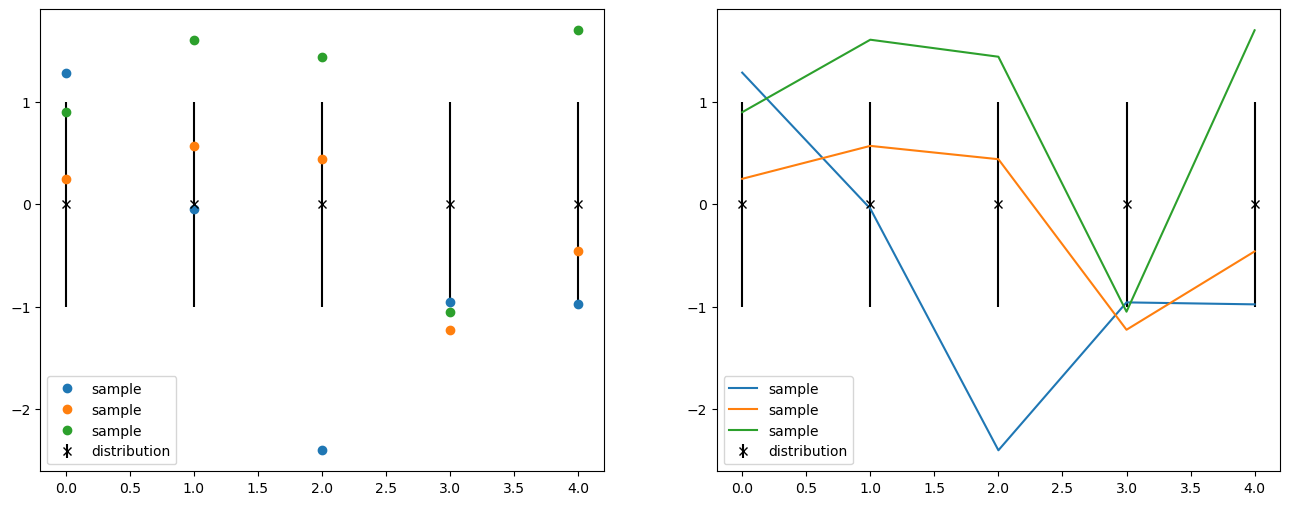

In [29]:
plt.figure(figsize=(16, 6))
n_dim = 5
x = torch.arange(n_dim)
gaussNd = distributions.MultivariateNormal(torch.zeros(n_dim), torch.eye(n_dim))
samples = gaussNd.sample((3, ))

plt.subplot(1, 2, 1)
plt.errorbar(x, gaussNd.mean, yerr=gaussNd.stddev, fmt='kx', label='distribution')
plt.plot(x, samples.T, 'o', label='sample')
plt.legend();
plt.subplot(1, 2, 2)
plt.errorbar(x, gaussNd.mean, yerr=gaussNd.stddev, fmt='kx', label='distribution')
plt.plot(x, samples.T, label='sample')
plt.legend();

Of course, it is not possible to represent a GP by a mean $\in \mathbb{R}^\infty$ and a covariance matrix $\in \mathbb{R}^{\infty \times \infty}$.
Instead, the mean function of a GP is represented by a function, $\mu : \mathbb{R} \to \mathbb{R}$.
Similarly, the covariance of a GP is represented by the so-called *kernel* funtion, $k : \mathbb{R} \times \mathbb{R} \to \mathbb{R}$.
The kernel function computes the covariance between any two points in the domain of the function.
Note that, similar to the covariance matrix, this function should be symmetric and positive definite.

The Radial Basis Function (RBF) kernel is a commonly used kernel in GPs for modelling smooth functions:

In [30]:
def rbf_kernel(x1: torch.Tensor, x2: torch.Tensor, 
               var: float = 1., width: float = 1.):
    """
    Radial Basis Function Kernel for GP.
    
    Parameters
    ----------
    x1 : torch.Tensor
        First (set of) input(s) for kernel evaluation.
    x2 : torch.Tensor
        Second (set of) input(s) for kernel evaluation.
    var : float, optional
        Variance of the kernel.
        This will be the maximum output value.
    width : float, optional
        Width of the smoothing window of the kernel.
        Specifies the range of input interactions.
    
    Returns
    -------
    cov : torch.Tensor
        The covariance between the two given points.
    """
    diff = (x1 - x2) / width
    cov = var * torch.exp(-diff ** 2 / 2)
    # "hack" to improve numerical stability
    return cov + 1e-5 * (x1 == x2)

GPs can do more than just model a distribution over functions.
Otherwise, they would not be so important in a machine learning context.
One of the main powers of a GP is its ability to model a distribution of functions that fit a set of data points.
This effectively allows the model to express its uncertainty in regions where no data is available.
The key concepts that are necessary to make this work are: *marginalisation* and *conditioning*.

###### Marginalisation

When summing (or integrating) over one of the "dimensions" of a GP, the resulting distribution will also be a GP.
Moreover, the marginal GP has the same kernel function and can be used to reconstruct the original GP.
E.g., consider the domain of a GP, $\mathcal{X}$, that is partitioned in $\mathcal{X}_A$ and $\mathcal{X}_B$.
Now, the mean of the GP can be expressed in terms of the means, $\mu_A$ and $\mu_B$, of the marginal GPs:

$$\mu(x) = \begin{cases}
    \mu_A(x) & x \in \mathcal{X}_A \\
    \mu_B(x) & x \in \mathcal{X}_B
\end{cases}$$

This means that we can partition the domain in arbitrary subsets without losing information.
When considering the GPs over the individual subset, we can also reconstruct the GP over the entire domain.

In practice, marginalisation allows us to interact with a GP through marginal GPs on individual data points.
Note that the GP with a finite set as domain is equivalent again to a multivariate distribution.
In other words: we can model GPs by simply considering multivariate distributions on selected points.
Remember that for multivariate distributions, we have

$$\boldsymbol{\Sigma} = \begin{bmatrix}
    \boldsymbol{\Sigma}_A & \boldsymbol{\Sigma}_{AB} \\
    \boldsymbol{\Sigma}_{BA} & \boldsymbol{\Sigma}_B
\end{bmatrix},$$

where $\boldsymbol{\Sigma}_{AB} = k(x_a, x_b)$ for $x_a \in \mathcal{X}_A$ and $x_b \in \mathcal{X}_B$

###### Conditioning

Similar to marginalisation, GPs are closed under conditioning, i.e., the result of conditioning a GP is still a GP.
Fitting a GP to a set of data points is therefore equivalent to conditioning the GP on that data.
Using the marginalisation properties of GPs, it suffices to have a discrete set of points for conditioning.
Similarly, the GP is generally evaluated for a discrete set of points.
Therefore, the conditioning of GPs can effectively be expressed as conditioning of multivariate distributions:

$$\begin{aligned}
    \boldsymbol{\mu}_{A \mid B} &= \boldsymbol{\mu}_A + \boldsymbol{\Sigma}_{AB} (\boldsymbol{\Sigma}_{B} + \sigma^2 \boldsymbol{I})^{-1} (\boldsymbol{y}_B - \boldsymbol{\mu_B}) \\
    \boldsymbol{\Sigma}_{A \mid B} &= \boldsymbol{\Sigma}_{A} - \boldsymbol{\Sigma}_{AB} (\boldsymbol{\Sigma}_{B} + \sigma^2 \boldsymbol{I})^{-1} \boldsymbol{\Sigma}_{BA}.
\end{aligned}$$

Here, $\boldsymbol{y}_B$ represents the function values for the given data.
The $\sigma^2$ term that is added to the variance of the given data allows to model the noise of these data points.

### Exercise 1: Gaussian Process (2 points)

Although the formulas look rather complicated, the implementation can be surprisingly easy 
(especially with a good numerical algebra library).
Note that the direct implementation of these formulas can result in numerical instabilities.
No need to bother about those instabilities for now, but don't use this code in production.

 > Implement the `update` and `evaluate` methods of `GaussianProcess`.
 > The `update` method should update the data on which the GP is conditioned.
 > Use the marginalisation properties to implement this update efficiently.
 > Also the inverse matrix for the conditioning should be pre-computed.
 > The `evaluate` method should compute the distribution for a set of given input points.

**Hint:** an error of the form `RuntimeError: cholesky_cpu: U(X,X) is zero, singular U` upon creating the distribution indicates that the covariance matrix is invalid. This is probably due to numerical errors.

In [31]:
class GaussianProcess:
    """ Implementation of Gaussian Processes. """
    
    def __init__(self, mean: callable, kernel: callable, **kwargs):
        """
        Parameters
        ----------
        mean : callable
            Mean function for the GP.
        kernel : callable
            Covariance function for the GP.
        """
        self.mean = mean
        self.kernel = lambda x1, x2: kernel(x1, x2, **kwargs)
        
        self.x = torch.empty(0)
        self.y = torch.empty(0)
        self.k_data = torch.empty(0, 0)
        self._inv_k = None
    
    def __call__(self, x: torch.Tensor):
        multivariate = self.evaluate(x)
        return multivariate.mean, multivariate.stddev
    
    def sample(self, x: torch.Tensor, num_samples: int = None):
        """
        Sample function values on a given domain.
        
        Parameters
        ----------
        x : (N, ) torch.Tensor
            The set of points to evaluate the sampled function for.
        num_samples: int, optional
            The number of functions to sample.
            
        Returns
        -------
        y : (num_samples, N) torch.Tensor
            The sampled function values.
        """
        num_samples = () if num_samples is None else (num_samples, )
        multivariate = self.evaluate(x)
        return multivariate.sample(num_samples)
        
    def update(self, x: torch.Tensor, y: torch.Tensor, noise_var: float = 0.):
        """
        Add reference points for conditioning.
        
        Parameters
        ----------
        x : (N, ) torch.Tensor
            The domain of the reference data points.
        y : (N, ) torch.Tensor
            The function values for the data points.
        noise_var : float or torch.Tensor, optional
            The amount of noise in the provided data.
            Can also be used to control numerical stability.
            
        Note
        ----
        This function also pre-computes the noise-enhanced covariance matrix,
        as well as it's inverse for the given data.
        """
        # YOUR CODE HERE
        # raise NotImplementedError()

        if self.x.shape[0] == 0:
            self.x = x
            self.y = y
        else:
            self.x = torch.cat([self.x, x])
            self.y = torch.cat([self.y, y])

        self.k_data = self.kernel(self.x[:, None], self.x[None, :]) + noise_var * torch.eye(len(self.x))
        self.l_data = torch.linalg.cholesky(self.k_data)
        self._inv_k = torch.cholesky_inverse(self.l_data)
    
    def evaluate(self, x: torch.Tensor):
        """
        Evaluate the distribution at a given set of points.
        
        Parameters
        ----------
        x : (N, ) torch.Tensor
            The points to evaluate.
        
        Returns
        -------
        y : (N, ) MultivariateNormal
            The distribution of function values at the given points.
            The distribution is conditioned on the data provided through `update`.
        """        
        # YOUR CODE HERE
        # raise NotImplementedError()
        if self.x.shape[0] == 0:
            mu_pred = self.mean(x)
            k_pred = self.kernel(x[:, None], x[None, :])
            return distributions.MultivariateNormal(mu_pred, k_pred)

        k_corr = self.kernel(x[:, None], self.x[None, :])
        k_pred = self.kernel(x[:, None], x[None, :])
        mu_pred = self.mean(x)

        mu, cov = self._get_theta_stable(mu_pred, k_pred, k_corr)

        return distributions.MultivariateNormal(mu, cov)
    
    def _get_theta(self, mu_pred, k_pred, k_corr):
        """ utility function for distribution computation """
        tmp = k_corr @ self._inv_k
        mu = mu_pred + tmp @ (self.y - self.mean(self.x))
        cov = k_pred - tmp @ k_corr.t()
        return mu, cov
    
    def _get_theta_stable(self, mu_pred, k_pred, k_corr):
        """ utility function for stable distribution computation """
        y = (self.y - self.mean(self.x))
        alpha = torch.cholesky_solve(y.unsqueeze(-1), self.l_data).squeeze(-1)
        mu = mu_pred + k_corr @ alpha
        v= torch.linalg.solve_triangular(self.l_data, k_corr.t(), upper=False)
        cov = k_pred - v.t() @ v
        return mu, cov

In [32]:
# sanity check
x = torch.rand(10)
gp = GaussianProcess(torch.zeros_like, rbf_kernel)
gp.update(x, torch.sin(x), noise_var=.1)
gp.update(-x, torch.sin(-x), noise_var=.1)
assert len(gp.x) == 2 * len(x), "update should accumulate data"
assert gp.k_data.shape == (2 * len(x), ) * 2, "forgotten covariance matrix?"
gp.evaluate(torch.linspace(-1., 1., 5))

MultivariateNormal(loc: torch.Size([5]), covariance_matrix: torch.Size([5, 5]))

In [33]:
#Test Cell do not delete!

In [34]:
#Test Cell do not delete!

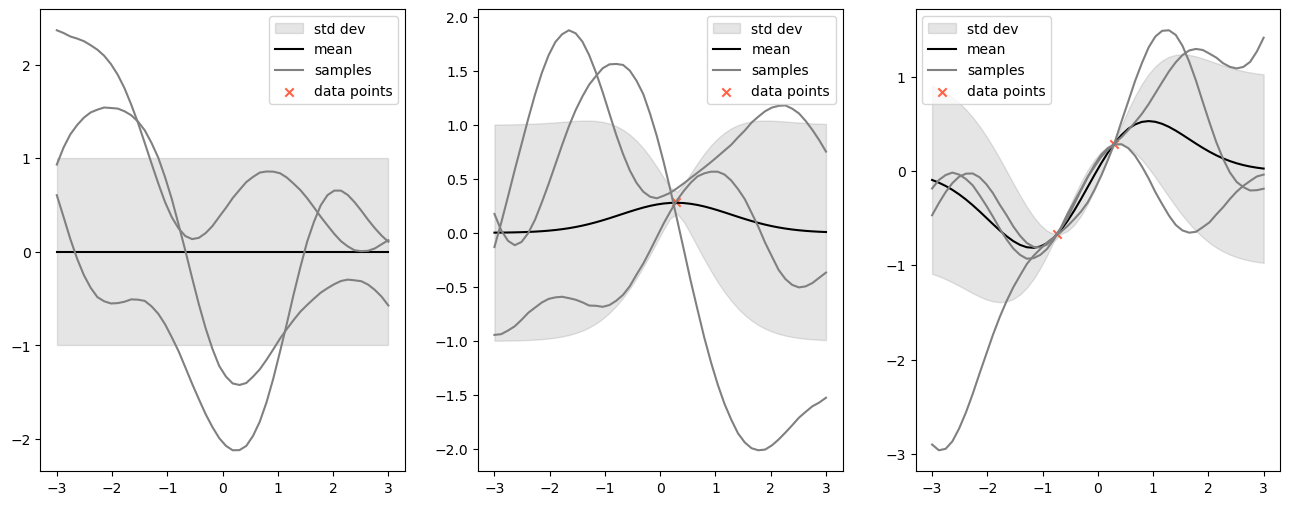

In [35]:
# visualisation
plt.figure(figsize=(16, 6))
x_test = torch.linspace(-3, 3, 50)

gp = GaussianProcess(torch.zeros_like, rbf_kernel)
plot_gp(x_test, gp, ax=plt.subplot(1, 3, 1));

xi = torch.rand(1)
gp.update(xi, torch.sin(xi), noise_var=.01)
plot_gp(x_test, gp, ax=plt.subplot(1, 3, 2));

xi = -torch.rand(1)
gp.update(xi, torch.sin(xi))
plot_gp(x_test, gp, ax=plt.subplot(1, 3, 3));

## Bayesian Neural Networks

In classical deep learning, the parameters for a single network are optimised.
This provides a deterministic mapping from inputs to predictions.
However, this deterministic mapping has no (inherent) way to express uncertainty about the prediction.
Using Bayesian techniques, it is possible to create distributions over networks, 
similar to how GPs model distributions over functions.

In [36]:
# set up MLP model
ref_mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 120, bias=False),
    nn.ReLU(),
    nn.Linear(120, 120, bias=False),
    nn.ReLU(),
    nn.Linear(120, 10, bias=False),
).to(device)
sgd = torch.optim.SGD(ref_mlp.parameters(), lr=1e-3, momentum=.9)

ce = nn.CrossEntropyLoss(reduction='sum')
train(ref_mlp, train_samples, ce, sgd, 
      valid_samples, {'ce': ce, 'acc': accuracy})

Epoch 00 - ce: 23023.12891, acc: 0.09850
Epoch 05 - ce: 1704.62280, acc: 0.96220
Epoch 10 - ce: 1884.42285, acc: 0.96410
Epoch 15 - ce: 2510.98755, acc: 0.96100
Epoch 20 - ce: 3294.52393, acc: 0.95650


Instead of learning a single network, the goal of Bayesian deep learning is to obtain a distribution over networks.
This can be achieved by learning a distribution over the weights of the network.
Concretely, the goal is to model the distribution of the parameters given the data, i.e., $p(\boldsymbol{W} \mid \mathcal{D})$.
Using Bayes' rule, this distribution can be written as

$$p(\boldsymbol{W} \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid \boldsymbol{W}) p(\boldsymbol{W})}{p(\mathcal{D})}.$$

The different components that are required to compute this *posterior* distribution are:

 - $p(\mathcal{D} \mid \boldsymbol{W})$: the *likelihood* of the parameters given a dataset.
   This is what regular deep learning optimises.
 - $p(\boldsymbol{W})$: the *prior* distribution, which provides an initial guess for the parameter distribution.
 - $p(\mathcal{D})$: the *evidence*, which provides information on how likely it is to obtain the given data.

The likelihood and prior distribution are easy enough to obtain.
However, in order to compute the evidence, the distrution of the data would be required.
Therefore, instead of directly computing the posterior distribution, an approximation is used.

The posterior distribution is typically approximated by an arbitrary parameterised distribution, $q$.
This parameterised distribution is commonly referred to as the *variational* distribution.
Typically, the variational distribution is chosen to be a Gaussian distribution.
Now, the task is to find the best possible parameters, $\theta$, for this distribution, so that 
$$q(\boldsymbol{W} \mathbin{;} \theta) \approx p(\boldsymbol{W} \mid \mathcal{D}).$$

It turns out that this fitting can be done by minimising the KL divergence between these two distributions.

### Exercise 2: Bayesian Neural Network (2 points)

In order to create a Bayesian network, we will need layers that provide some extra functionality.
Most importantly, parameters will have to be sampled from a variational distribution.
It will also be useful to be able to compute the KL divergence between variational and other distributions.

 > Implement the `GaussianLinear` module so that it can be used as Bayesian variant of a `Linear` module.
 > You can ignore bias parameters for this implementation.
 > Use a Gaussian distribution with fixed variance as variational distribution.
 > Make use of the [`torch.distributions`](https://pytorch.org/docs/stable/distributions.html) module for working with distributions.
 > Don't forget that gradients should be able to flow to the module parameters.
 
**Hint:** you will probably want to think about a workaround to move the pytorch distribution to GPU!

In [46]:
class GaussianLinear(nn.Module):
    """ Simple Bayesian fully connected layer. """
    
    def __init__(self, in_features: int, out_features: int, std: float = 0.075):
        """
        Parameters
        ----------
        in_features : int
            Number of input features.
        out_features : int
            Number of output features.
        std : float, optional
            Standard deviation for the variational distribution.
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # YOUR CODE HERE
        # raise NotImplementedError()
        import math
        self.mean = nn.Parameter(torch.Tensor(out_features, in_features))
        self.log_std = nn.Parameter(torch.Tensor(out_features, in_features).fill_(std))
        nn.init.kaiming_uniform_(self.mean, a=math.sqrt(5))
        
    # NOTE: this solution allows parameters to be moved to GPU (after init)
    @property
    def weight_dist(self):       
        # YOUR CODE HERE
        # raise NotImplementedError()
        std = self.log_std.exp().clamp(min=1e-5, max=10)
        return distributions.Normal(self.mean, std)
        
    def forward(self, x):       
        # YOUR CODE HERE
        # raise NotImplementedError()
        weights = self.weight_dist.rsample()
        return x @ weights.t()
    
    def kl_div(self, other: distributions.Distribution):
        """
        Compute the KL divergence from a given distribution.
        
        Parameters
        ----------
        other : Distribution
            The distribution to compute the divergence from.
        
        Returns
        -------
        kl_div : torch.Tensor
            Scalar KL divergence from `other` 
            to the variational distribution of the weights. 
        """        
        # BEGINN SOLUTION
        # GRADING - compute KL div between variational and given distribution: .5 points
        kl = distributions.kl_divergence(self.weight_dist, other)
        # GRADING - sum KL div over parameters: .5 points
        return kl.sum()

In [47]:
# sanity check
x = torch.randn(7, 784)
lin = GaussianLinear(784, 10)
err = lin(x).sum() +  lin.kl_div(distributions.Normal(0, 1))
err.backward()
assert sum(par.grad.sum() for par in lin.parameters() if par.grad is not None) != 0, "no gradients"

In [48]:
#Test Cell do not delete!

In [49]:
#Test Cell do not delete!

In [50]:
#Test Cell do not delete!

The Kullback-Leibler divergence between the variational and posterior distribution can be written as (verify for yourself):

$$\begin{align}
  \mathrm{D}_\mathrm{KL}(q \mathbin{\|} p_\mathrm{post}) 
  &= \mathbb{E}_{W \sim q}\left[\log \frac{q(W)}{p(W \mid \mathcal{D})}\right] \\
  %&= \mathbb{E}_{W \sim q}\left[\log \frac{q(W) p(\mathcal{D})}{p(\mathcal{D} \mid W) p(W)}\right] \\
  %&= \mathbb{E}_{W \sim q}\left[\log \frac{q(W)}{p(W)} - \log p(\mathcal{D} \mid W) + \log p(\mathcal{D})\right] \\
  &= \mathrm{D}_\mathrm{KL}(q \mathbin{\|} p_\mathrm{prior}) - \mathbb{E}_{W \sim q}[\log p(\mathcal{D} \mid W)] + \log p(\mathcal{D}).
\end{align}$$

Finally, minimising w.r.t. the parameter of the variational distribution gives the desired variational parameters

$$\theta^* = \arg\min_\theta \left\{\mathbb{E}_{W \sim q}[-\log p(\mathcal{D} \mid W)] + \mathrm{D}_\mathrm{KL}(q \mathbin{\|} p_\mathrm{prior})\right\}.$$

Note that the expression to be minimised corresponds to the *negative* Evidence Lower Bound (ELBO).

The first term of the negative ELBO is the expectation of the negative log-likelihood.
If we ignore the expectation (for now), this is exactly the objective in regular deep learning.
The expectation is there to account for the non-determinism of Bayesian models.
It turns out that this expectation can often be well approximated using a Monte Carlo method (sampling):
$$\mathbb{E}_{W \sim q}[-\log p(\mathcal{D} \mid W)] \approx \frac{1}{S} \sum_{s=1}^S -\log p(\mathcal{D} \mid \boldsymbol{W}_{s}),$$
where $S$ is the number of samples and $\boldsymbol{W}_s$ is the $s$-th set of randomly sampled weights for the model.
In practice, it is possible to use $S = 1$ if the dataset is large enough.

The second term of the negative ELBO, on the other hand, can be interpreted as a regularisation term.
Intuitively, this term makes sure that the posterior stays close to the prior distribution.
As a matter of fact, a lot of regularisation techniques can be derived in this way 
(see [this paper](https://papers.nips.cc/paper/2011/hash/7eb3c8be3d411e8ebfab08eba5f49632-Abstract.html) for a nice overview).

### Exercise 3: negative ELBO (1 point)

In order to optimise our variational parameters, we need a proper loss function.
Apart from the regular loss function, we also need to properly incorporate the KL divergence.

> Implement the `NELBOLoss` module so that it computes the negative ELBO.

In [51]:
class NELBOLoss(nn.Module):
    """ Negative ELBO loss. """
    
    DEFAULT_PRIOR = distributions.Normal(0, 1)
    
    def __init__(self, nll: callable, kl_div: callable, regulariser: float = 1., 
                 prior: distributions.Distribution = None):
        """
        Parameters
        ----------
        nll : callable
            Function that computes the negative log-likelihood
            from model logits and target labels.
        kl_div : callable
            Function that computes the KL divergence for the model at hand.
        regulariser : float, optional
            Value to weight the KL divergence (relative to the NLL)
        prior : Distribution, optional
            Prior distribution for the parameters of the Bayesian model.
        """
        super().__init__()
        self.nll = nll
        self.kl_div = kl_div
        
        self.regulariser = regulariser
        self.prior = self.DEFAULT_PRIOR if prior is None else prior
        
    def forward(self, logits, y):        
        # YOUR CODE HERE
        # raise NotImplementedError()
        loss_nll = self.nll(logits, y)
        loss_kl = self.kl_div(self.prior)
        nelbo = loss_nll + self.regulariser * loss_kl
        return nelbo

In [52]:
# sanity check
x, y = torch.randn(7, 784), torch.randint(10, size=(7, ))
lin = GaussianLinear(784, 10)
nelbo = NELBOLoss(nn.CrossEntropyLoss(), lin.kl_div)
err = nelbo(lin(x), y)
assert err is not None

In [53]:
#Test Cell do not delete!

### Exercise 4: Bayesian balancing (0 points)

Just as in regular deep learning, it is important to balance the likelihood and regularisation terms.
The only way to get a feeling for this balance, is to actually optimise a Bayesian network.

 > Use the `BayesianSequential` module to create an MLP with Bayesian layers for MNIST classification.
 > You can copy the architecture from the reference MLP at the beginning of the notebook.
 > Make use of the `regulariser` parameter to balance the NLL and KL divergence in the loss.
 > It should be pretty clear when things work and when they don't, but 70% accuracy should be the minimum.
>> Feel free to experiment with the code below
 
**Hint:** Mathematically, the dataset likelihood is the product over single-sample likelihoods.

In [55]:
# set up MLP model
ref_mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 120, bias=False),
    nn.ReLU(),
    nn.Linear(120, 120, bias=False),
    nn.ReLU(),
    nn.Linear(120, 10, bias=False),
).to(device)
sgd = torch.optim.SGD(ref_mlp.parameters(), lr=1e-3, momentum=.9)

ce = nn.CrossEntropyLoss(reduction='sum')
train(ref_mlp, train_samples, ce, sgd, 
      valid_samples, {'ce': ce, 'acc': accuracy})

gauss_mlp = BayesianSequential(
    nn.Flatten(),
    GaussianLinear(784, 120),
    nn.ReLU(),
    GaussianLinear(120, 120),
    nn.ReLU(),
    GaussianLinear(120, 10),
).to(device)
sgd = optim.SGD(gauss_mlp.parameters(), lr=1e-4, momentum=.9)

ce = nn.CrossEntropyLoss(reduction='sum')
# combine regular loss with KL divergence of model
# use weighting to control balance between two terms
nelbo = NELBOLoss(ce, gauss_mlp.kl_div, 1 / len(train_samples))
val_metrics = {
    'ce': ce, 
    'kl': lambda logits, y: gauss_mlp.kl_div(nelbo.prior) / len(train_samples),
    'acc': accuracy,
}

# successful training (>70% accuracy)
train(gauss_mlp, train_samples, nelbo, sgd, valid_samples, val_metrics)


Epoch 00 - ce: 23041.09375, acc: 0.11540
Epoch 05 - ce: 1834.05383, acc: 0.96150
Epoch 10 - ce: 2358.50244, acc: 0.96190
Epoch 15 - ce: 2436.82568, acc: 0.96060
Epoch 20 - ce: 2947.25342, acc: 0.95940
Epoch 00 - ce: 36240848.00000, kl: 1.76610, acc: 0.11530


ValueError: Expected parameter scale (Tensor of shape (120, 120)) of distribution Normal(loc: torch.Size([120, 120]), scale: torch.Size([120, 120])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[ 1.6671,  0.3443, 10.0000,  ...,  2.6124,  1.1435,  0.7533],
        [ 1.1223,  2.7010,  1.7871,  ...,  0.8090,  1.0771,  0.8185],
        [ 1.0989,  1.3403,  0.2049,  ...,  1.3316,  1.0257,  1.2242],
        ...,
        [ 0.2210,  0.3216, 10.0000,  ..., 10.0000,  1.1813,  0.5086],
        [ 1.4962,  0.9572,  0.3199,  ...,  2.2640,  1.1944,  1.0709],
        [ 0.6053,  0.7859, 10.0000,  ...,  0.8794,  1.0530,  1.1165]],
       grad_fn=<ClampBackward1>)